A.S. Lundervold, v.02.04.24

> **UNDER CONSTRUCTION**

# Introduction

As we've learned, deep neural networks are powerful tools for learning complex patterns in data. A trained neural network provides hierarchical representations of data, tailored to the specific task at hand. 

<img src="https://github.com/HVL-ML/DAT255/blob/main/nbs/assets/VGG_neural_network.png?raw=true">

These representations **can be extracted**. For example, at by grabbing the activations from the later hidden layers. These extracted representations can be used with other machine learning models, perhaps combined with other features. 

We'll explore this idea in this notebook by exctracting representations from the last hidden layer of a trained CNN, and combine them with other features to train a classifier. 

This extraction can be achieved by using **hooks** in PyTorch.

> Remember that we've used hooks before: when constructing class activatio maps (CAMs) in the notebooks `DAT255-2.0-asl-data_collection_model_deployment.ipynb` and `DAT255-3.2-asl-adversarial-dogs-vs-cats.ipynb`.

**The data**

We'll use a dataset of histology images collected from brain tumors. The dataset was collected by the authors of [1] below, and further explored by [2]. We'll use these references as our guide.

[1] Mobadersany et al. in "Predicting cancer outcomes from histology and genomics using convolutional networks." Proceedings of the National Academy of Sciences 115.13 (2018): E2970-E2979. https://www.pnas.org/content/pnas/115/13/E2970.full.pdf.<br><br>
[2] R. J. Chen et al., "Pathomic Fusion: An Integrated Framework for Fusing Histopathology and Genomic Features for Cancer Diagnosis and Prognosis," in IEEE Transactions on Medical Imaging, vol. 41, no. 4, pp. 757-770, April 2022, doi: [10.1109/TMI.2020.3021387](http://doi.org/10.1109/TMI.2020.3021387)

# Setup

In [ ]:
# This is a quick check of whether the notebook is currently running on Kaggle, 
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.
import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [ ]:
if kaggle:
    !pip install -Uqq fastai

In [1]:
%matplotlib inline
from pathlib import Path
from fastai.vision.all import *

In [2]:
# Sample data set
# Set this to True if you want to use a sample data set.
# Note that using the sample data will significantly reduce the model's performance.

if kaggle:
    sample = True
else:
    sample = False

In [3]:
NB_DIR = Path.cwd()
if sample:
    DATA = Path.home()/'data'/'dat255'/'TCGA-images-sample'
else:
    DATA = Path.home()/'data'/'dat255'/'TCGA-images'
DATA.mkdir(parents=True, exist_ok=True)

# Downloading the data

Depending on whether you're using the sample dataset or the full dataset, this step might take some time. The full dataset is approximately 3.8 GB.

In [4]:
if not sample:
    imgdataurl = 'https://www.dropbox.com/s/jka111c16q8cn6x/PNAS-images.zip?dl=1'
    dataurl = 'https://www.dropbox.com/s/zogil8mxr2p9ajy/pathfusion.zip?dl=1'

elif sample:
    imgdataurl = 'https://www.dropbox.com/scl/fi/sgbq6g0ee0tv883cxic3s/PNAS-images_sample.zip?rlkey=0mi6ssa6tozjuymys7vqk6pt5&dl=1'
    dataurl = 'https://www.dropbox.com/scl/fi/k0homftq297barehs7xpb/pathfusion_sample.zip?rlkey=xaatvgie6tn8iqx6lt51ja07a&dl=1'

else:
    raise ValueError('sample variable must be either True or False')

In [5]:
# Download the image data
if not os.path.isfile(DATA/'PNAS-images.zip'):
    urllib.request.urlretrieve(imgdataurl, DATA/'PNAS-images.zip')

In [7]:
# Extract the image data
if not os.path.isdir(DATA/'images'):
    shutil.unpack_archive(DATA/'PNAS-images.zip', DATA/'images')


In [8]:
# Download and extract the metadata
if not os.path.isfile(DATA/'pathfusion.zip'):
    urllib.request.urlretrieve(dataurl, DATA/'pathfusion.zip')
    if not os.path.isfile(DATA/'metadata'):
        shutil.unpack_archive(DATA/'pathfusion.zip', DATA/'metadata')

In [9]:
# Delete all the zip files in the DATA directory
delete_zips = False

if delete_zips:
    for file in os.listdir(DATA):
        if file.endswith('.zip'):
            os.remove(DATA/file)

# Inspect the data

In [10]:
DATA.ls()

(#5) [Path('/home/alex/data/dat255/TCGA-images/pathfusion.zip'),Path('/home/alex/data/dat255/TCGA-images/images'),Path('/home/alex/data/dat255/TCGA-images/metadata'),Path('/home/alex/data/dat255/TCGA-images/PNAS-images.zip'),Path('/home/alex/data/dat255/TCGA-images/sample_images')]

We've stored the images in `DATA/'images'` and the other information in `DATA/'metadata'`.

In [11]:
(DATA/'images').ls()

(#1506) [Path('/home/alex/data/dat255/TCGA-images/images/TCGA-HT-A5RA-01Z-00-DX1.F5DA3E78-30A6-41C5-9B50-410E795EF591_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-IK-7675-01Z-00-DX1.1afabdc4-ee6b-4a8a-8f9f-2bdead91ee76_2.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-12-0619-01Z-00-DX2.e305c038-1dd0-422f-87dd-8edaeace224d_2.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-02-0068-01Z-00-DX1.B1C4CAA6-6493-4AA1-9A48-B4336BB8D16A_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-12-0616-01Z-00-DX3.b426f381-b175-4a6d-957e-2dbfed42caeb_2.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-HT-7855-01Z-00-DX1.D1CFAF92-BC0B-443C-8A5A-48147BD0FB84_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-VM-A8CD-01Z-00-DX3.E93E4734-17DD-40F9-AE98-3E2146E6F9F8_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-FG-A87Q-01Z-00-DX3.426D47B6-2D6C-4F6E-9546-2E121A9DDAB2_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-HW

In [12]:
(DATA/'metadata').ls()

(#5) [Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_000_cv_splits.csv'),Path('/home/alex/data/dat255/TCGA-images/metadata/sample'),Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_100rnaseq_cv_splits.csv'),Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_000_cv_splits_img.csv'),Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_100rnaseq_cv_splits_img.csv')]

Let's take a look at some of the metadata:

In [13]:
tmidata_1 = pd.read_csv(DATA/'metadata'/'tmidata_000_cv_splits_img.csv')
tmidata_1.head()

,TCGA ID,Histomolecular subtype,Histology,Grade,Molecular subtype,censored,Survival months,imgs,cv_1,cv_2,...,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15
0,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,0,0,...,0,0,0,1,0,0,0,0,0,0
1,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,0,0,...,0,0,0,1,0,0,0,0,0,0
2,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,0,0,...,0,0,0,1,0,0,0,0,0,0
3,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,0,0,...,1,0,0,1,0,1,0,1,0,0
4,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,0,0,...,1,0,0,1,0,1,0,1,0,0


The 'tmidata_000_cv_splits_img.csv' file contains the following information: 

| Feature               | Description                                                                                                                                 |
|-----------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| `TCGA-ID`             | A unique identifier for each patient sample in [The Cancer Genome Atlas](https://www.cancer.gov/ccg/research/genome-sequencing/tcga), linking clinical, genomic, and histopathology data.                  |
| `Histomolecular subtype` | Classifies tumors based on histological examination and molecular genetics, integrating information like genetic mutations and tissue appearance. |
| `Histology`           | Categorizes the microscopic anatomy of tumor tissues, ranging from cellular morphology to tissue organization, on a numerical scale.         |
| `Grade`               | Indicates the tumor's deviation from normal tissue and aggressiveness, with higher values suggesting more aggressive or poorly differentiated tumors. |
| `Molecular subtype`   | Represents specific genetic expressions or mutations relevant to the cancer's behavior, encoded as numerical values.                        |
| `censored`            | Binary indicator of whether the observation is censored ('1') or uncensored ('0'), essential for survival analysis.                         |
| `Survival months`     | Quantifies the time, in months, a patient has survived following their diagnosis or the start of the study.                                 |
| `imgs`                | Refers to filenames of digitized histology slide images, linking visual data to specific patient samples for model training.                |



In addition, the file contains information about the cross-validation splits used in the original paper.


In [14]:
pd.set_option('display.max_columns', None)

tmidata_2 = pd.read_csv(DATA/'metadata'/'tmidata_000_cv_splits.csv')
tmidata_2.head()

,TCGA ID,Histomolecular subtype,Histology,Grade,Molecular subtype,censored,Survival months,codeletion,idh mutation,EGFR,MDM4,MYC,BRAF,EZH2,MET,SMO,KIAA1549,CREB3L2,NTRK1,PRCC,BLM,NTRK3,CRTC3,CDKN2A,CDKN2B,FGFR2,TSHR,TCL1A,TRIP11,GOLGA5,GPHN,DICER1,TCL6,EBF1,ITK,RPL22,CDKN2C,LCP1,RB1,IRF4,FGFR1OP,MLLT4,MYB,ROS1,TNFAIP3,GOPC,CARD11,JAK2,STK11,PTEN,1q,2p,2q,3p,3q,4p,4q,5p,5q,6p,6q,7p,7q,8p,8q,9p,9q,10p,10q,11p,11q,12p,12q,13q,14q,15q,16p,16q,17p,17q,18p,18q,19p,20p,20q,21q,22q,imgs,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15
0,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.232,0.296,0.296,0.351,0.351,0.0,0.0,0.0,0.0,0.0,0.0,1.259,1.259,-0.402,-0.402,0.335,0.335,0.000,0.000,-0.132,-0.132,0.335,0.335,0.12,0.0,0.000,0.0,0.0,-0.211,-0.211,0.0,0.0,0.0,-0.133,-0.133,0.591,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.232,0.296,0.296,0.351,0.351,0.0,0.0,0.0,0.0,0.0,0.0,1.259,1.259,-0.402,-0.402,0.335,0.335,0.000,0.000,-0.132,-0.132,0.335,0.335,0.12,0.0,0.000,0.0,0.0,-0.211,-0.211,0.0,0.0,0.0,-0.133,-0.133,0.591,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.232,0.296,0.296,0.351,0.351,0.0,0.0,0.0,0.0,0.0,0.0,1.259,1.259,-0.402,-0.402,0.335,0.335,0.000,0.000,-0.132,-0.132,0.335,0.335,0.12,0.0,0.000,0.0,0.0,-0.211,-0.211,0.0,0.0,0.0,-0.133,-0.133,0.591,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.804,0.804,0.000,0.000,0.000,0.000,-0.866,-0.866,0.000,0.000,0.000,0.000,0.00,0.0,-0.865,0.0,0.0,0.760,0.760,0.0,0.0,0.0,0.000,0.000,0.000,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0
4,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.804,0.804,0.000,0.000,0.000,0.000,-0.866,-0.866,0.000,0.000,0.000,0.000,0.00,0.0,-0.865,0.0,0.0,0.760,0.760,0.0,0.0,0.0,0.000,0.000,0.000,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0


This file contain extensive genetic data about each case. We will use the following two features from this file later in this notebook:

| Feature               | Description                                                                                                                                 |
|-----------------------|-----------------------------------------------------------------------------------------------------------------|
| `codeletion`          | Indicates the presence ('1') or absence ('0') of a simultaneous deletion of genetic material from chromosome arms 1p and 19q, a feature often associated with certain types of brain tumors and their response to therapy. |
| `idh mutation`        | Denotes whether a mutation in the isocitrate dehydrogenase (IDH) gene is present ('1') or absent ('0'), which is significant in the classification and prognosis of various cancers, especially gliomas. |


Later, we'll combine some of the above information with the images to make predictive models. Therefore, let's make a dataframe that includes the image paths and some of the metadata.

> Note that there are multiple images belonging to a single TCGA ID. These are different views on the same tumor. For simplicity, we're going to treat each image as an independent training sample. Note that this is not optimal! The different views may correspond to different grades.

# Prepare the data

In [15]:
columns = [
    'TCGA ID',
     'Histomolecular subtype',
     'Histology',
     'Molecular subtype',
     'codeletion',
     'idh mutation', 
     'imgs', 
     'Grade'
]

In [16]:
df = tmidata_2[columns].copy()

In [17]:
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0
2,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,2.0
3,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,2.0
4,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,2.0


In [18]:
len(df)

1505

We want to predict the tumor grade from the images (and other features). Let's check for missing labels and also whether the classes are balanced.

In [19]:
df.Grade.value_counts()

 2.0    654
 1.0    408
 0.0    396
-1.0     47
Name: Grade, dtype: int64

We note that there is some imbalance, and that some of the labels seem to be missing (i.e., they are `-1.0`). We drop the missing data. 

In [20]:
df.drop(df.loc[df.Grade == -1].index, inplace=True)

In [21]:
df.Grade.value_counts()

2.0    654
1.0    408
0.0    396
Name: Grade, dtype: int64

How about missing data in the other features? *

In [22]:
# Check for missing values encoded as NaN values
print("NaN values:")
for col in df.columns:
    print(f'{col}: {df[col].isnull().sum()}')
print()

# Check for missing values encoded as -1:
print("-1 values:")
for col in df.columns:
    print(f'{col}: {len(df.loc[df[col] == -1])}')


NaN values:
TCGA ID: 0
Histomolecular subtype: 0
Histology: 0
Molecular subtype: 0
codeletion: 0
idh mutation: 0
imgs: 0
Grade: 0

-1 values:
TCGA ID: 0
Histomolecular subtype: 0
Histology: 0
Molecular subtype: 133
codeletion: 0
idh mutation: 0
imgs: 0
Grade: 0


We not that there seems to be some cases with missing data in the `Molecular subtype` feature. Rather than drop these, we'll replace them with the most common value and add an indicator variable for whether the value was missing.

In [23]:
df['Molecular subtype'].value_counts()

 0    611
 1    387
 2    327
-1    133
Name: Molecular subtype, dtype: int64

In [24]:
# Add an indicator for the missing values in the 'Molecular subtype' column
df['missing_molecular_subtype'] = df['Molecular subtype'].apply(lambda x: 1 if x == -1 else 0)

# Replace the missing values encoded as -1 with 0 in the 'Molecular subtype' column

df['Molecular subtype'] = df['Molecular subtype'].apply(lambda x: 0 if x == -1 else x)

In [25]:
df['Molecular subtype'].value_counts()

0    744
1    387
2    327
Name: Molecular subtype, dtype: int64

In [26]:
df['missing_molecular_subtype'].value_counts()

0    1325
1     133
Name: missing_molecular_subtype, dtype: int64

In [27]:
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade,missing_molecular_subtype
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0,0
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0,0
2,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,2.0,0
3,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,2.0,0
4,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,2.0,0


# Training an image classifier

## Validation data

We set aside the data from a random selection of TCGA IDs for validation.

> Note: Later, we'll use the cross-validation splits from the original paper to compare our results with theirs.

In [28]:
# Grab a random 20% of the TCGA IDs for validation
np.random.seed(42)
val_ids = np.random.choice(df['TCGA ID'].unique(), size=int(0.2*len(df['TCGA ID'].unique())), replace=False)

print(len(val_ids))
val_ids[:10]

147


array(['TCGA-S9-A6U6', 'TCGA-02-0099', 'TCGA-HT-7676', 'TCGA-12-0691',
       'TCGA-14-1795', 'TCGA-HT-8015', 'TCGA-02-0285', 'TCGA-HT-7686',
       'TCGA-HT-8019', 'TCGA-HT-A616'], dtype=object)

In [29]:
# Mark these as is_valid=True in the dataframe, while the rest is marked as is_valid=False
df['is_valid'] = df['TCGA ID'].apply(lambda x: x in val_ids)
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade,missing_molecular_subtype,is_valid
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0,0,False
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0,0,False
2,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,2.0,0,False
3,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,2.0,0,False
4,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,2.0,0,False


In [30]:
df.is_valid.value_counts()

False    1207
True      251
Name: is_valid, dtype: int64

## Create dataloaders

We create dataloaders with some data augmentation.

In [31]:
dls = ImageDataLoaders.from_df(
    df, path=DATA/'images', fn_col='imgs', label_col='Grade', 
    valid_col='is_valid',
    bs=32,
    item_tfms=None,
    batch_tfms=[Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), 
                Normalize.from_stats(*imagenet_stats), 
                Resize(900, method='zeros')])

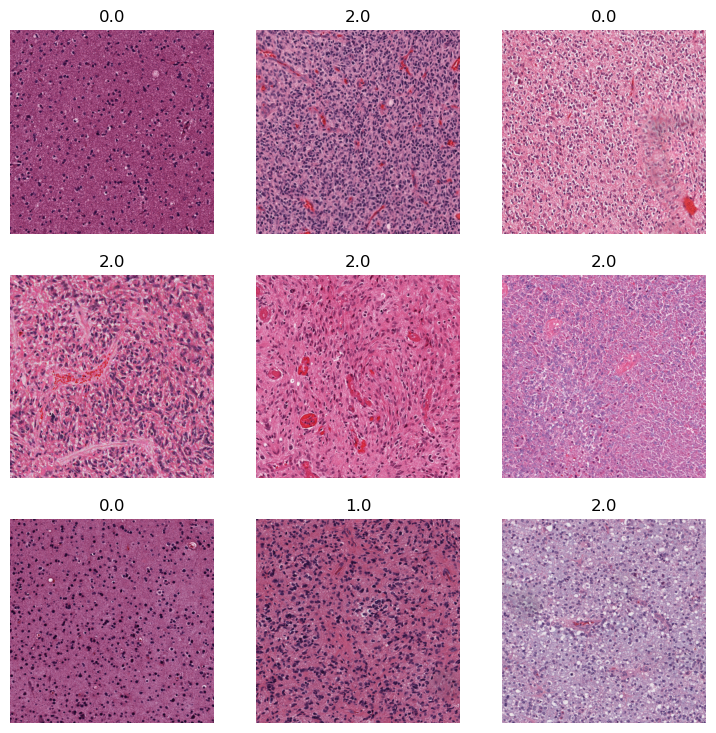

In [32]:
dls.show_batch()

## Create a learner

In [33]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
custom_head = create_head(nf=512, n_out=3, lin_ftrs=[128], concat_pool=True)

In [35]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=3, bias=False)
)

In [36]:
learn = vision_learner(dls, arch=resnet34, 
                       custom_head=custom_head,
                       metrics=[accuracy, RocAuc(), F1Score(average='micro'), F1Score(average=None)],
                       cbs=[ShowGraphCallback()]).to_fp16()

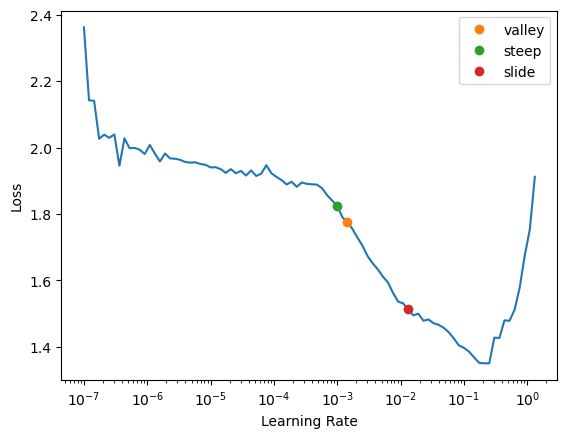

In [37]:
lr = learn.lr_find(suggest_funcs=(valley, steep, slide))

In [ ]:
learn.fit_one_cycle(5, lr.slide)

> **Note:** Later, we'll see how we can improve the model performance.

# Extracting representations from CNNs

We use PyTorch hooks to extract the output of the last hidden layer of our trained model. This gives us a 128-dimensional representation of each image, which we can use as features in other models.

In [38]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [39]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [40]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

We store the activations in our dataframe

In [41]:
from torchvision import transforms
import torch

to_tensor = transforms.ToTensor()

def process_row(row):
    img = PILImage.create(DATA/'images'/row['imgs'])
    img = to_tensor(img)
    img = img.unsqueeze(0)
    img = img.to(learn.dls.device)
    with torch.no_grad():
        _ = learn.model.eval()(img)
    activations = hook_output.stored.cpu().numpy()
    return pd.Series(activations.flatten())

# Apply the function to each row of the dataframe
activations_df = df.apply(process_row, axis=1)
activations_df.columns = [f'activation_{i}' for i in range(learn.model[-1][-5].out_features)]


In [42]:
# Join the activations dataframe with the original dataframe
df = df.join(activations_df)

In [43]:
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade,missing_molecular_subtype,is_valid,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,activation_10,activation_11,activation_12,activation_13,activation_14,activation_15,activation_16,activation_17,activation_18,activation_19,activation_20,activation_21,activation_22,activation_23,activation_24,activation_25,activation_26,activation_27,activation_28,activation_29,activation_30,activation_31,activation_32,activation_33,activation_34,activation_35,activation_36,activation_37,activation_38,activation_39,activation_40,activation_41,activation_42,activation_43,activation_44,activation_45,activation_46,activation_47,activation_48,activation_49,activation_50,activation_51,activation_52,activation_53,activation_54,activation_55,activation_56,activation_57,activation_58,activation_59,activation_60,activation_61,activation_62,activation_63,activation_64,activation_65,activation_66,activation_67,activation_68,activation_69,activation_70,activation_71,activation_72,activation_73,activation_74,activation_75,activation_76,activation_77,activation_78,activation_79,activation_80,activation_81,activation_82,activation_83,activation_84,activation_85,activation_86,activation_87,activation_88,activation_89,activation_90,activation_91,activation_92,activation_93,activation_94,activation_95,activation_96,activation_97,activation_98,activation_99,activation_100,activation_101,activation_102,activation_103,activation_104,activation_105,activation_106,activation_107,activation_108,activation_109,activation_110,activation_111,activation_112,activation_113,activation_114,activation_115,activation_116,activation_117,activation_118,activation_119,activation_120,activation_121,activation_122,activation_123,activation_124,activation_125,activation_126,activation_127
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0,0,False,-4.715601,-3.741887,-6.073699,-2.099280,-7.985415,-9.524705,5.368698,-2.396144,2.872558,-1.819923,-2.107697,-2.765141,-4.059078,-6.827280,-0.531087,5.365128,9.021607,-2.783740,-1.458977,4.511487,1.860761,-2.332176,6.545377,-10.696003,-0.460205,-0.002277,8.675264,0.387459,-4.761428,10.993830,5.381240,-5.975491,8.000463,-7.196479,1.611315,-6.490181,-3.474625,-3.618346,-0.085559,-1.085898,2.207967,-0.467530,-0.154797,-1.984935,3.951591,9.049443,-2.929265,10.332163,-6.159691,-4.775898,-8.148438,1.618103,14.328505,-4.775362,-4.035692,-4.933111,0.649961,5.406436,2.002554,2.767898,10.150434,-4.103717,9.620132,-2.730072,-7.119071,5.798310,0.010243,1.557398,8.283422,3.379291,5.193998,4.367089,-1.896931,1.931068,-6.507192,1.678363,-3.102459,-2.069790,-3.792136,0.764126,1.669470,6.182479,3.958467,-2.275837,-13.100635,3.764778,-2.854101,-5.586087,-9.007584,8.254541,-4.364839,-3.451688,-8.122710,1.949800,7.285067,-7.803705,2.503527,13.045137,0.680283,-0.597733,-5.651589,-3.679551,-3.149519,6.309624,5.416934,4.720540,-0.227650,-5.497304,0.977790,-0.339053,-0.360352,-8.924160,-0.520141,-2.564447,4.410463,10.364395,-1.123644,9.927347,-4.538263,-2.595186,2.410011,0.636607,-1.799222,-4.045681,4.646316,4.416197,9.979577,-7.597161
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0,0,False,-2.034793,-6.799641,-4.279924,-1.246838,-6.121395,-7.705376,4.076536,-0.138813,6.454883,-1.359554,-2.001810,-3.754270,-2.836821,-5.825876,0.825204,3.619174,8.660044,-2.131679,-2.953856,7.938064,-0.914638,-1.055852,2.481617,-7.560104,-2.094447,-1.027043,7.056877,-1.754524,-4.257238,8.027769,3.027065,-5.178869,6.317469,-5.822179,1.301594,-5.698856,-0.890922,-4.914289,-2.047503,-1.569288,1.665080,2.254754,0.832998,0.514870,2.536928,8.855990,-1.863093,9.745001,-3.099148,-4.558223,-11.050068,1.595072,10.430359,-5.240722,-4.421128,-2.714851,-0.926073,6.121559,3.307487,5.651490,8.467611,-3.671929,

# Training models on CNN-derived features

Now, we take the CNN-derived features and use them to train a Random Forest classifier. We also explore how combining these features with other available data affects the model's performance.

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def train_rf_model(df, features):
    """
    Train a Random Forest model on specified features and target 'Grade'.
    Automatically handles categorical variables by one-hot encoding.
    
    :param df: DataFrame containing the dataset.
    :param features: List of columns to be used as features.
    :return: Tuple of accuracy, weighted average F1 score, and classification report.
    """
    X = df[features].copy()
    y = df['Grade'].copy()
    X = pd.get_dummies(X, drop_first=True)  # One-hot encode categoricals directly
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    acc = report['accuracy']
    f1_score = report['weighted avg']['f1-score']

    return acc, f1_score, classification_report(y_test, y_pred)



Here are the results:

In [46]:
from prettytable import PrettyTable

activation_columns = df.filter(like='activation_').columns.tolist()
non_activation_columns = [col for col in df.columns if col not in activation_columns + ['TCGA ID', 'Grade', 'imgs', 'is_valid']]
all_columns = [col for col in df.columns if col not in ['TCGA ID', 'Grade', 'imgs', 'is_valid']]

# Define a table to store the results
table = PrettyTable()
table.field_names = ["Title", "Accuracy", "F1 Score"]

# Training on different feature sets
for title, features in [("Training without activations", non_activation_columns),
                        ("Training with activations only", activation_columns),
                        ("Training with activations + other features", all_columns)]:
    acc, f1, _ = train_rf_model(df, features)
    table.add_row([title, round(acc,3), round(f1,3)])

print(table)

+--------------------------------------------+----------+----------+
|                   Title                    | Accuracy | F1 Score |
+--------------------------------------------+----------+----------+
|        Training without activations        |  0.736   |  0.736   |
|       Training with activations only       |  0.716   |  0.702   |
| Training with activations + other features |  0.829   |  0.827   |
+--------------------------------------------+----------+----------+


> Note that if you're using the sample data, your results when training on the activations will likely be significantly worse than those achieved using the full dataset.

# TODO: Extra: improving our image classifier

Note that to compare our grade prediction results with those of reference [1], we need to use the same validation setup as them. We can achieve this by training and evaluating our model 15 times on the 15 different cross validation folds determined by [1] and [2].

_TBA_

<img src="https://github.com/HVL-ML/DAT255/blob/main/nbs/assets/TMI-grade-results.png?raw=true">